In [2]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import scipy.signal

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

# GaussInput

In [5]:
def one_dimensional_peak(p, std, a, size=10):
    x = np.arange(size)

    activations = a * np.exp(-0.5*(x-p)**2/std**2)

    return activations

def two_dimensional_peak(p, std, a, size=[10,10]):
    
    x = np.arange(size[1])
    y = np.arange(size[0])
    grid_x, grid_y = np.meshgrid(x, y)
    

    activations = a * np.exp(-0.5*((grid_x - p[1])**2/std[1]**2 + \
                                   (grid_y - p[0])**2/std[0]**2))

    return activations

def three_dimensional_peak(p, std, a, size=[10,10,10]):
    x = np.arange(size[0])
    y = np.arange(size[1])
    z = np.arange(size[2])
    grid_x, grid_y, grid_z = np.meshgrid(x, y, z)

    activations = a * np.exp(-0.5 * ((grid_x - p[0])**2 /std[0]**2 + \
                                     (grid_y - p[1])**2 /std[1]**2 + \
                                     (grid_z - p[2])**2 /std[2]**2))

    return activations

def make_gaussian(sizes, centers, sigmas, a):
    if len(sizes) == 1:
        activations = one_dimensional_peak(centers[0], sigmas[0], a, sizes[0])
        
    elif len(sizes) == 2:
        activations = two_dimensional_peak(centers, sigmas, a, sizes)
        
    elif len(sizes) == 3:
        activations = three_dimensional_peak(centers, sigmas, a, sizes)
        
    # TODO: what to do if len(sizes) not between 1 and 3?
    return activations

In [6]:
class GaussInput(object):
    def __init__(self, sizes, centers, sigmas, a, name=None):
        
        # add asserts to check if sizes same length as centers and sigmas
        self.sizes = sizes
        self.centers = centers
        self.sigmas = sigmas
        self.a = a
        self.name = name
        
    def make_node(self):
        if self.name is not None:
            self.node = nengo.Node(make_gaussian(self.sizes, self.centers, self.sigmas, self.a).flatten(),
                                   label=self.name)
        else:
            self.node = nengo.Node(make_gaussian(self.sizes, self.centers, self.sigmas, self.a).flatten())

In [25]:
model1 = nengo.Network()

with model1:
    
    gi = GaussInput([10,10], [2,4], [4,2], 3)
    gi.make_node()
    
    probe_gi = nengo.Probe(gi.node)
    
sim1 = nengo.Simulator(model1)
with sim1:
    sim1.run(0.01)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

0.02850608484017967 3.0


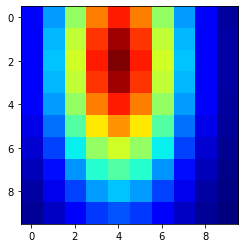

In [26]:
# check GaussInput
print(np.min(sim1.data[probe_gi][1]), np.max(sim1.data[probe_gi][1]))

plt.figure()
plt.imshow(sim1.data[probe_gi][1].reshape(10,10), cmap='jet')
plt.show()

# ConstMatrix

In [6]:
class ConstMatrix(object):
    def __init__(self, sizes, value):
        self.sizes = sizes
        self.value = value
        
    def make_node(self):
        return nengo.Node(np.ones(np.prod(self.sizes))*self.value)

In [7]:
model2 = nengo.Network()

with model2:
    
    cm = ConstMatrix([10,10], 42).make_node()
    
    probe_cm = nengo.Probe(cm)
    
sim2 = nengo.Simulator(model2)
with sim2:
    sim2.run(0.01)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [8]:
print(sim2.data[probe_cm][1])

[42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42.
 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42.
 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42.
 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42.
 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42. 42.
 42. 42. 42. 42. 42. 42. 42. 42. 42. 42.]


# ComponentMultiply

In [35]:
class ComponentMultiply(object):
    # TODO: adapt ComponentMultiply to be able to deal with inputs of different
    # sizes
    def __init__(self, inp_size1, inp_size2):
        self.inp_size1 = inp_size1
        self.inp_size2 = inp_size2
        if len(self.inp_size1) >= len(self.inp_size2):
            self.out_size = self.inp_size1
        else:
            self.out_size = self.inp_size2
        
    def update(self, inp):
        # get the index of where input1 and input2 are seperated
        sep = np.prod(self.inp_size1)
        inp1 = inp[:sep]
        inp2 = inp[sep:]
        
        if self.inp_size1 == self.inp_size2 or self.inp_size1 == [] or self.inp_size2 == []:
            return inp1 * inp2
        
        else:
            inp1 = inp1.reshape(*self.inp_size1)
            inp2 = inp2.reshape(*self.inp_size2)
            return (inp1 * inp2).flatten()
    
    def make_node(self):
        return nengo.Node(lambda t, x: self.update(x), 
                          size_in=int(np.prod(self.inp_size1)+np.prod(self.inp_size2)), 
                          size_out=np.prod(self.out_size))

In [36]:
model3 = nengo.Network()

with model3:
    
    inp1 = nengo.Node(np.arange(16))
    inp2 = nengo.Node(np.ones(16)*3)
    inp3 = nengo.Node([1,2,-1,2])
    inp4 = nengo.Node([2])
    compmul = ComponentMultiply([4,4],[4,4]).make_node()
    compmul2 = ComponentMultiply([4,4], []).make_node()
    
    nengo.Connection(inp1, compmul[:16], synapse=0)
    nengo.Connection(inp2, compmul[16:], synapse=0)
    nengo.Connection(inp4, compmul2[16:], synapse=0)
    nengo.Connection(inp1, compmul2[:16], synapse=0)
    
    probe_compmul = nengo.Probe(compmul)
    probe_compmul2 = nengo.Probe(compmul2)
    
sim3 = nengo.Simulator(model3)
with sim3:
    sim3.run(0.01)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [37]:
print(sim3.data[probe_compmul][1])
print()
print(sim3.data[probe_compmul2][1])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27. 30. 33. 36. 39. 42. 45.]

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30.]


# StaticGain

In [12]:
class StaticGain(object):
    def __init__(self, sizes, gain_factor):
        self.sizes = sizes
        self.gain_factor = gain_factor
        
    def update(self, inp):
        return inp * self.gain_factor
    
    def make_node(self):
        return nengo.Node(lambda t, x: self.update(x), size_in=np.prod(self.sizes))

In [13]:
model4 = nengo.Network()

with model4:
    
    inp1 = nengo.Node(np.arange(16))
    sg = StaticGain([4,4], 3).make_node()
    
    nengo.Connection(inp1, sg, synapse=0)

    probe_sg = nengo.Probe(sg)
    
sim4 = nengo.Simulator(model4)
with sim4:
    sim4.run(0.01)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [14]:
print(sim4.data[probe_sg][:3])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27. 30. 33. 36. 39. 42. 45.]
 [ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27. 30. 33. 36. 39. 42. 45.]]


# Flip

In [15]:
class Flip(object):
    def __init__(self, sizes, flip_dimensions):
        self.sizes = sizes
        self.flip_dimensions = flip_dimensions
        
    def update(self, inp):
        
        out = inp.reshape(*self.sizes)
        if self.flip_dimensions[0]:
            out = np.flip(out, axis=0)
        if self.flip_dimensions[1]:
            out = np.flip(out, axis=1)
            
        return out.flatten()
    
    def make_node(self):
        return nengo.Node(lambda t, x: self.update(x), size_in=np.prod(self.sizes), 
                          size_out=np.prod(self.sizes))
            

In [16]:
model5 = nengo.Network()

with model5:
    
    inp1 = nengo.Node(np.arange(16))
    flip_tt = Flip([4,4], [True, True]).make_node()
    flip_tf = Flip([4,4], [True, False]).make_node()
    flip_ff = Flip([4,4], [False, False]).make_node()
    
    nengo.Connection(inp1, flip_tt, synapse=0)
    nengo.Connection(inp1, flip_tf, synapse=0)
    nengo.Connection(inp1, flip_ff, synapse=0)

    probe_tt = nengo.Probe(flip_tt)
    probe_tf = nengo.Probe(flip_tf)
    probe_ff = nengo.Probe(flip_ff)
    
sim5 = nengo.Simulator(model5)
with sim5:
    sim5.run(0.01)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [17]:
print(sim5.data[probe_tt][1])
print()
print(sim5.data[probe_tf][1])
print()
print(sim5.data[probe_ff][1])
print()

[15. 14. 13. 12. 11. 10.  9.  8.  7.  6.  5.  4.  3.  2.  1.  0.]

[12. 13. 14. 15.  8.  9. 10. 11.  4.  5.  6.  7.  0.  1.  2.  3.]

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]



# Projection

In [1]:
def reduce(inp, dimension_mapping, compression_type):
    # get axis/axes to reduce
    axis_reduce = tuple([int(key) for key in dimension_mapping if type(dimension_mapping[key]) == bool])
    # reduce inp by using sum or max
    if compression_type == 'sum':
        out = np.sum(inp, axis=axis_reduce)
    elif compression_type == 'max':
        out = inp.max(axis=axis_reduce)
    
    # transpose array st order of dimensions is as given in dimension mapping
    dim_order = [int(value) for value in dimension_mapping.values() if type(value) == int]
    # print(dim_order, dimension_mapping)
    out = out.transpose(*dim_order)
    
    return out


def add_dimensions(inp, dimension_mapping, out_sizes):
    
    added_dims = list(np.arange(len(out_sizes)))
    mapped_dims = [int(value) for value in dimension_mapping.values()]
    [added_dims.remove(dim) for dim in mapped_dims]

    # add dimensions
    for dim in added_dims:
        # add the dimension
        inp = np.expand_dims(inp, axis=dim)
        # repeat dimension to get right size
        inp = np.repeat(inp, repeats=out_sizes[dim], axis=dim)
        
    return inp


class Projection(object):
    def __init__(self, sizes_out, sizes_in, dimension_mapping, compression_type,
                 name=None):
        self.sizes_out = sizes_out
        self.sizes_in = sizes_in
        self.dimension_mapping = dimension_mapping
        self.compression_type = compression_type
        self.name = name
        
    def update(self, inp):
        # reshape inp
        if self.sizes_in != []:
            out = inp.reshape(*self.sizes_in)
        else:
            out = inp
        
        # either downsizing
        if len(self.dimension_mapping) > len(self.sizes_out):
            out = reduce(out, self.dimension_mapping, self.compression_type)
            
        # or upsizing
        elif len(self.sizes_out) > len(self.dimension_mapping):
            out = add_dimensions(out, self.dimension_mapping, self.sizes_out)
            
        return out.flatten()
            
        
    def make_node(self):
        if self.name is not None:
            self.node = nengo.Node(lambda t, x: self.update(x), 
                          size_in=int(np.prod(self.sizes_in)) if self.sizes_in != [] else 1, 
                          size_out=int(np.prod(self.sizes_out)) if self.sizes_out != [] else 1,
                          label=self.name)
        else:
            self.node = nengo.Node(lambda t, x: self.update(x), 
                          size_in=int(np.prod(self.sizes_in)) if self.sizes_in != [] else 1, 
                          size_out=int(np.prod(self.sizes_out)) if self.sizes_out != [] else 1)

In [4]:
# example dimension mapping for 3 dims to 2 dims
dm1 = {"0": "1", "1": False, "2": "0"} 
# example dimension mapping for 3 dims to 1 dim
dm2 = {"0": False, "1": "0", "2": False} 
# example dimension mapping for 3 dims to 0 dims
dm5 = {"0": False, "1": False, "2": False}

print(np.arange(27).reshape(3,3,3).transpose(1,0,2).reshape(3,9))
print()
print(reduce(np.arange(27).reshape(3,3,3), dm2, 'max'))
print()
print(reduce(np.arange(27).reshape(3,3,3), dm5, 'sum'))

[[ 0  1  2  9 10 11 18 19 20]
 [ 3  4  5 12 13 14 21 22 23]
 [ 6  7  8 15 16 17 24 25 26]]

[20 23 26]

351


In [5]:
# example dimension mapping for 2 dims to 3 dims
dm3 = {"0": "1", "1": "0"}
# example dimension mapping for 1 dim to 3 dims
dm4 = {"0": "2"}
# example dimension mapping for 0 dims to 2 dims
dm6 = {}
    
print(add_dimensions(np.arange(9).reshape(3,3), dm3, [3,3,2]))
print()
print(add_dimensions(np.arange(4), dm4, [2,3,4]))
print()
print(add_dimensions(1, dm6, [4,3]))

[[[0 0]
  [1 1]
  [2 2]]

 [[3 3]
  [4 4]
  [5 5]]

 [[6 6]
  [7 7]
  [8 8]]]

[[[0 1 2 3]
  [0 1 2 3]
  [0 1 2 3]]

 [[0 1 2 3]
  [0 1 2 3]
  [0 1 2 3]]]

[[1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]]


In [7]:
model6 = nengo.Network()

with model6:
    
    # inputs
    inp1 = nengo.Node(np.arange(3))
    inp2 = nengo.Node(np.arange(9))
    inp3 = nengo.Node(np.arange(27))
    inp0 = nengo.Node([2])
    
    # several example projections
    pj_12 = Projection([3,3], [3], {"0": "1"}, 'sum')
    pj_12.make_node()
    pj_13 = Projection([3,3,3], [3], dm4, 'max')
    pj_13.make_node()
    pj_23 = Projection([3,3,3], [3,3], {"0": "1", "1": "2"}, 'sum')
    pj_23.make_node()
    pj_21 = Projection([3], [3,3], {"0": "0", "1": False}, 'sum')
    pj_21.make_node()
    pj_31 = Projection([3], [3,3,3], dm2, 'sum')
    pj_31.make_node()
    pj_32 = Projection([3,3], [3,3,3], dm1, 'sum')
    pj_32.make_node()
    pj_20 = Projection([], [3,3], {"0": False, "1": False}, 'max')
    pj_20.make_node()
    pj_02 = Projection([3,3], [], {}, 'max')
    pj_02.make_node()
    
    # connections
    nengo.Connection(inp1, pj_12.node, synapse=0)
    nengo.Connection(inp1, pj_13.node, synapse=0)
    nengo.Connection(inp2, pj_23.node, synapse=0)
    nengo.Connection(inp2, pj_21.node, synapse=0)
    nengo.Connection(inp3, pj_31.node, synapse=0)
    nengo.Connection(inp3, pj_32.node, synapse=0)
    nengo.Connection(inp0, pj_02.node, synapse=0)
    nengo.Connection(inp2, pj_20.node, synapse=0)

    # probes
    probe_12 = nengo.Probe(pj_12.node)
    probe_13 = nengo.Probe(pj_13.node)
    probe_23 = nengo.Probe(pj_23.node)
    probe_21 = nengo.Probe(pj_21.node)
    probe_31 = nengo.Probe(pj_31.node)
    probe_32 = nengo.Probe(pj_32.node)
    probe_02 = nengo.Probe(pj_02.node)
    probe_20 = nengo.Probe(pj_20.node)
    
sim6 = nengo.Simulator(model6)
with sim6:
    sim6.run(0.01)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [8]:
print('Input1')
print(sim6.data[probe_12][1,:].reshape(3,3))
print()
print(sim6.data[probe_13][1,:].reshape(3,3,3))
print()
print('Input2')
print(sim6.data[probe_21][1,:])
print()
print(sim6.data[probe_23][1,:].reshape(3,3,3))
print()
print(sim6.data[probe_20][1])
print()
print('Input3')
print(sim6.data[probe_31][1,:])
print()
print(sim6.data[probe_32][1,:].reshape(3,3))
print()
print('Input0')
print()
print(sim6.data[probe_02][1].reshape(3,3))

Input1
[[0. 1. 2.]
 [0. 1. 2.]
 [0. 1. 2.]]

[[[0. 1. 2.]
  [0. 1. 2.]
  [0. 1. 2.]]

 [[0. 1. 2.]
  [0. 1. 2.]
  [0. 1. 2.]]

 [[0. 1. 2.]
  [0. 1. 2.]
  [0. 1. 2.]]]

Input2
[ 3. 12. 21.]

[[[0. 1. 2.]
  [3. 4. 5.]
  [6. 7. 8.]]

 [[0. 1. 2.]
  [3. 4. 5.]
  [6. 7. 8.]]

 [[0. 1. 2.]
  [3. 4. 5.]
  [6. 7. 8.]]]

[8.]

Input3
[ 90. 117. 144.]

[[ 9. 36. 63.]
 [12. 39. 66.]
 [15. 42. 69.]]

Input0

[[2. 2. 2.]
 [2. 2. 2.]
 [2. 2. 2.]]


In [44]:
model = nengo.Network()

with model:
    gi = GaussInput([20], [5], [2], 1)
    gi.make_node()
    
    proj_to3 = Projection([20,20,20], [20], {'0': 2}, 'max')
    proj_to3.make_node()
    proj_to1 = Projection([20], [20,20,20], {'0':False, '1':False, '2':0}, 'max')
    proj_to1.make_node()
    
    proj_to3_1 = Projection([20,20,20], [20], {'0': 1}, 'max')
    proj_to3_1.make_node()
    proj_to1_1 = Projection([20], [20,20,20], {'0':False, '1':0, '2':False}, 'max')
    proj_to1_1.make_node()
    
    proj_to3_2 = Projection([20,20,20], [20], {'0': 0}, 'max')
    proj_to3_2.make_node()
    proj_to1_2 = Projection([20], [20,20,20], {'0':False, '1':0, '2':False}, 'max')
    proj_to1_2.make_node()
    
    nengo.Connection(gi.node, proj_to3.node, synapse=0)
    nengo.Connection(proj_to3.node, proj_to1.node, synapse=0)
    probe_1 = nengo.Probe(proj_to3.node)
    probe_2 = nengo.Probe(proj_to1.node)
    probe_3 = nengo.Probe(gi.node)
    
    nengo.Connection(gi.node, proj_to3_1.node, synapse=0)
    nengo.Connection(proj_to3_1.node, proj_to1_1.node, synapse=0)
    probe_4 = nengo.Probe(proj_to3_1.node)
    probe_5 = nengo.Probe(proj_to1_1.node)
    
    nengo.Connection(gi.node, proj_to3_2.node, synapse=0)
    nengo.Connection(proj_to3_2.node, proj_to1_2.node, synapse=0)
    probe_6 = nengo.Probe(proj_to3_2.node)
    probe_7 = nengo.Probe(proj_to1_2.node)

    
sim = nengo.Simulator(model)

with sim:
    sim.run(0.1)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

2.289734845645553e-11 1.0


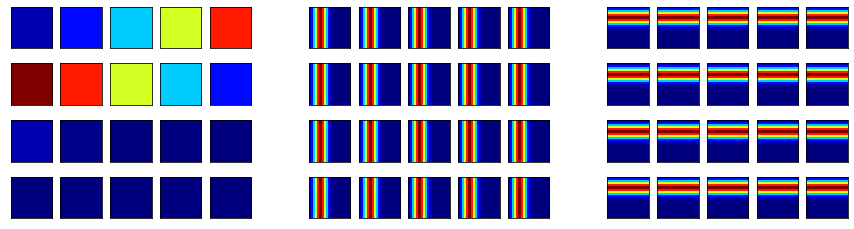

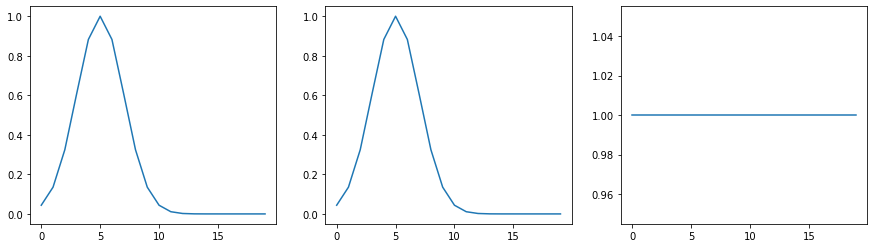

In [45]:


proj_data = sim.data[probe_1][2].reshape(20,20,20)
min, max = np.min(proj_data), np.max(proj_data)
print(min, max)
proj_data_1 = sim.data[probe_4][2].reshape(20,20,20)
proj_data_2 = sim.data[probe_6][2].reshape(20,20,20)

plt.figure(figsize=(15,4))
for i in range(20):
    row = int(i/5)*17
    inds = [row+(i%5)+1, row+(i%5)+7, row+(i%5)+13]
    plt.subplot(4,17,inds[0])
    plt.imshow(proj_data[:,:,i], vmin=min, vmax=max, cmap='jet')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(4,17,inds[1])
    plt.imshow(proj_data_1[:,:,i], vmin=min, vmax=max, cmap='jet')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(4,17,inds[2])
    plt.imshow(proj_data_2[:,:,i], vmin=min, vmax=max, cmap='jet')
    plt.xticks([])
    plt.yticks([])
    
plt.show()

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(sim.data[probe_2][2])
plt.subplot(1,3,2)
plt.plot(sim.data[probe_5][2])
plt.subplot(1,3,3)
plt.plot(sim.data[probe_7][2])
plt.show()


# Convolution

In [7]:
class GaussKernel(object):
    def __init__(self, c, sigma, normalize=True, dims=2):
        self.c = c
        self.sigma = sigma
        self.normalize = normalize
        self.kernel_width = int(np.ceil(sigma*5)) # limit is always 5 
        # kernel width should always be an odd number --> like that in cedar
        if self.kernel_width % 2 == 0:
            self.kernel_width += 1
        self.dims = dims
        
        x = np.arange(self.kernel_width)
        cx = self.kernel_width//2
        
        if self.dims == 1 or self.dims == 0:
            dx = np.abs(x - cx)
            
        elif self.dims == 2:
            grid_x, grid_y = np.meshgrid(x, x)
            dx = np.sqrt((grid_x - cx)**2 + (grid_y - cx)**2)
         
        elif self.dims == 3:
            grid_x, grid_y, grid_z = np.meshgrid(x, x, x)
            dx = np.sqrt((grid_x - cx)**2 + (grid_y - cx)**2 + (grid_z - cx)**2)
            
        kernel_matrix = np.exp(-dx**2 / (2*self.sigma**2))
        if self.normalize:
            kernel_matrix /= np.sum(kernel_matrix)
        self.kernel_matrix = self.c * kernel_matrix
        
        # if the kernel is 0-dimensional it only consists of the central scalar value
        # need to compute from 1-dimensional kernel for normalizaton to work correctly
        if self.dims == 0:
            self.kernel_matrix = self.kernel_matrix[cx]
            
    def __call__(self):
        return self.kernel_matrix
    
    
class BoxKernel(object):
    ''' Implementation of the BoxKernel of cedar.
        Since the BoxKernel is only used with 0-dimensional fields in the 
        architecture this is a simplified implementation of the BoxKernel
        without the width parameter which is only needed for 1- or higher 
        dimensional fields.
    '''
    def __init__(self, amplitude):
        # dimensionality of BoxKernel always 0
        self.dims = 0 
        self.amplitude = amplitude
        self.kernel_matrix = amplitude
        
    def __call__(self):
        return self.kernel_matrix
    

def pad_and_convolve(inp, kernel, border):
    
    # test if input consists of more than one number, i.e. field not 0-dimensional
    if inp.shape != ():
        # compute padding values
        kernel_width = kernel.shape[0]
        pad_width_f = kernel_width//2
        pad_width_b = kernel_width//2 if kernel_width % 2 == 1 else kernel_width//2 - 1 

        # translate border type to boundary mode
        mode = 'wrap' if border == 'cyclic' else 'constant'
        # pad the input
        inp_padded = np.pad(inp, pad_width=(pad_width_f, pad_width_b), mode=mode)
    
    # otherwise the kernel is just a scalar and can directly be convolved with the 
    # scalar input
    else:
        inp_padded = inp
    # perform the convolution
    conv = scipy.signal.convolve(inp_padded, kernel, mode='valid')
    
    return conv
    
class Convolution(object):
    ''' Has two inputs of same size: First input is the kernel for the 
        convolution, second input is the matrix to convolve with. Since they
        always have the same size in the spatial reasoning architecture I only
        implemented this case here for simplicity. 
    '''
    def __init__(self, sizes, border_type, name=None):
        self.sizes = sizes
        self.border_type = border_type
        self.name = name
        
    def update(self, inp):
        kernel = inp[:int(np.prod(self.sizes))].reshape(*self.sizes)
        matrix = inp[int(np.prod(self.sizes)):].reshape(*self.sizes)
        return pad_and_convolve(matrix, kernel, self.border_type).flatten()
    
    def make_node(self):
        if self.name is not None:
            self.node = nengo.Node(lambda t, x: self.update(x), size_in=int(np.prod(self.sizes)*2), 
                          size_out=int(np.prod(self.sizes)), label=self.name)
        else:
            self.node = nengo.Node(lambda t, x: self.update(x), size_in=int(np.prod(self.sizes)*2), 
                          size_out=int(np.prod(self.sizes)))

In [24]:
model6 = nengo.Network()

sizes = [50,50]
with model6:
    
    
    inp_conv = GaussInput(sizes, [24,24], [2,2], 5)
    inp_conv.make_node()
#     kernel = nengo.Node(GaussKernel(5,3))
    kernel = GaussInput(sizes, [15,15], [2,2], 1)
    kernel.make_node()
    conv = Convolution(sizes, 'zero-filled borders')
    conv.make_node()

    nengo.Connection(inp_conv.node, conv.node[np.prod(sizes):], synapse=0)
    con_fn = lambda x: abssigmoid(x-0.5)
    nengo.Connection(kernel.node, conv.node[:np.prod(sizes)], synapse=0, function=con_fn)
    
    probe_inp_conv = nengo.Probe(inp_conv.node)
    probe_conv = nengo.Probe(conv.node)
    probe_kernel = nengo.Probe(kernel.node)
    
sim6 = nengo.Simulator(model6)
with sim6:
    sim6.run(0.01)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

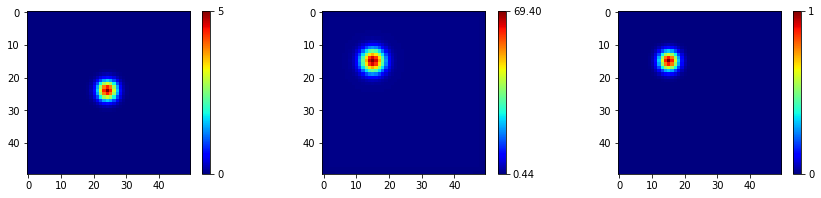

In [25]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.imshow(sim6.data[probe_inp_conv][1].reshape(*sizes), cmap='jet')
plt.colorbar(ticks=[sim6.data[probe_inp_conv][1].min(),
                    sim6.data[probe_inp_conv][1].max()])
plt.subplot(1,3,2)
plt.imshow(sim6.data[probe_conv][1].reshape(*sizes), cmap='jet')
plt.colorbar(ticks=[sim6.data[probe_conv][1].min(),
                    sim6.data[probe_conv][1].max()])

plt.subplot(1,3,3)
plt.imshow(sim6.data[probe_kernel][1].reshape(*sizes), cmap='jet')
plt.colorbar(ticks=[sim6.data[probe_kernel][1].min(),
                    sim6.data[probe_kernel][1].max()])

plt.show()
# checked the result visually by creating the same architecture in cedar 

# SpatialTemplate

In [3]:
class AbsSigmoid(object):
    def __init__(self, beta=100, threshold=0):
        self.beta = beta
        self.threshold = threshold
    def __call__(self, x):
        return 0.5 * (1 + self.beta * (x-self.threshold) / (1 + self.beta * np.abs(x-self.threshold)))

abssigmoid = AbsSigmoid()

def create_template(sizes, invert_sides, horizontal_pattern, sigma_th, 
                    mu_r, sigma_r, sigma_sigmoid):
    if invert_sides:
        invert_sides = -1
    else:
        invert_sides = 1
        
    size_x = sizes[0]
    size_y = sizes[1]
    
    shift_x = ((size_x - 1) / 2)
    shift_y = ((size_y - 1) / 2)
    
    x_grid, y_grid = np.meshgrid(np.arange(size_x), np.arange(size_y))
    
    x_shifted = x_grid - shift_x
    y_shifted = y_grid - shift_y
    
    x = x_shifted
    y = y_shifted 
    
    if horizontal_pattern:
        x = y_shifted
        y = x_shifted
        
    th = np.arctan2(y, invert_sides * x)
    r = np.log(np.sqrt(x**2 + y**2))
    
    gaussian = np.exp(-0.5 * th**2 / sigma_th**2 \
                      - 0.5 * (r - mu_r)**2 / sigma_r**2)
    sigmoid = invert_sides * abssigmoid(x)
    
    pattern = (1 - sigma_sigmoid) * gaussian + sigma_sigmoid * sigmoid
    
    return pattern.transpose(1,0)
    
    
class SpatialTemplate(object):
    def __init__(self, sizes, invert_sides, horizontal_pattern, sigma_th_hor, 
                 mu_r, sigma_r, sigma_sigmoid_fw):
        self.sizes = sizes
        self.invert_sides = invert_sides
        self.horizontal_pattern = horizontal_pattern
        self.sigma_th_hor = sigma_th_hor
        self.mu_r = mu_r
        self.sigma_r = sigma_r
        self.sigma_sigmoid_fw = sigma_sigmoid_fw
        
    def make_node(self):
        return nengo.Node(create_template(self.sizes, self.invert_sides, self.horizontal_pattern,
                                          self.sigma_th_hor, self.mu_r, self.sigma_r, 
                                          self.sigma_sigmoid_fw).flatten())

In [190]:
model7 = nengo.Network()

with model7:
    
#     inp1 = nengo.Node(np.arange(16))
    down = SpatialTemplate(sizes=[50,50], invert_sides=False, horizontal_pattern=False,
                              sigma_th_hor=0.4, mu_r=2, sigma_r=3.5, sigma_sigmoid_fw=0).make_node()
    right = SpatialTemplate(sizes=[50,50], invert_sides=False, horizontal_pattern=True,
                              sigma_th_hor=0.4, mu_r=2, sigma_r=3.5, sigma_sigmoid_fw=0).make_node()
    up = SpatialTemplate(sizes=[50,50], invert_sides=True, horizontal_pattern=False,
                              sigma_th_hor=0.4, mu_r=2, sigma_r=3.5, sigma_sigmoid_fw=0).make_node()
    left = SpatialTemplate(sizes=[50,50], invert_sides=True, horizontal_pattern=True,
                              sigma_th_hor=0.4, mu_r=2, sigma_r=3.5, sigma_sigmoid_fw=0).make_node()


    probe_down = nengo.Probe(down)
    probe_right = nengo.Probe(right)
    probe_up = nengo.Probe(up)
    probe_left = nengo.Probe(left)

    
sim7 = nengo.Simulator(model7)
with sim7:
    sim7.run(0.01)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

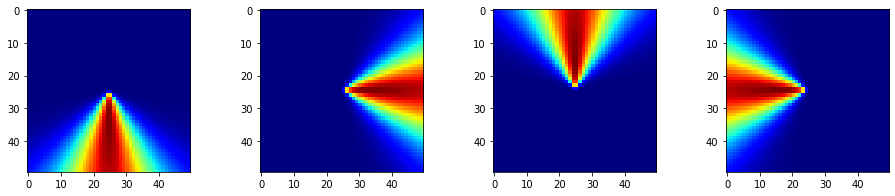

In [191]:
plt.figure(figsize=(16,3))

plt.subplot(141)
plt.imshow(sim7.data[probe_down][1].reshape(50,50), cmap='jet')
plt.subplot(142)
plt.imshow(sim7.data[probe_right][1].reshape(50,50), cmap='jet')
plt.subplot(143)
plt.imshow(sim7.data[probe_up][1].reshape(50,50), cmap='jet')
plt.subplot(144)
plt.imshow(sim7.data[probe_left][1].reshape(50,50), cmap='jet')

In [179]:
# mat = np.zeros(5,5)
# for i in range(5):
#     for j in range(5):
#         mat[i,j] = 

# Boost

# Combining modules test

In [196]:
model_comb = nengo.Network()

with model_comb:
    
    north = SpatialTemplate([50,50], True, False, sigma_th_hor=0.4, mu_r=2,
                            sigma_r=3.5, sigma_sigmoid_fw=0).make_node()
    east = SpatialTemplate([50,50], False, True, sigma_th_hor=0.4, mu_r=2,
                           sigma_r=3.5, sigma_sigmoid_fw=0).make_node()
    
    prod_obj = ComponentMultiply([50,50])
    prod1 = prod_obj.make_node()
    prod2 = prod_obj.make_node()
    mat = ConstMatrix([50,50], 42).make_node()
    proj = Projection(sizes_in=[50,50], sizes_out=[]).make_node()

    nengo.Connection(north, prod1[:50*50], synapse=0)
    nengo.Connection(east, prod1[50*50:], synapse=0)
    nengo.Connection(mat, prod2[:50*50], synapse=0)
    nengo.Connection(prod1, prod2[50*50:], synapse=0)
    
    probe_prod1 = nengo.Probe(prod1)
    probe_prod2 = nengo.Probe(prod2)
    
sim_comb = nengo.Simulator(model_comb)

with sim_comb:
    sim_comb.run(0.2)
    

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

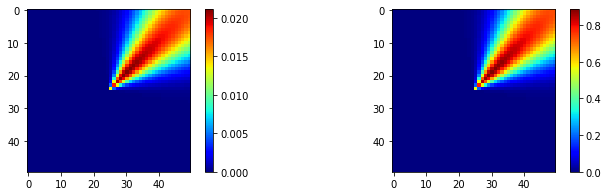

In [201]:
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(sim_comb.data[probe_prod1][2].reshape(50,50), cmap='jet')
plt.colorbar()

plt.subplot(122)
plt.imshow(sim_comb.data[probe_prod2][2].reshape(50,50), cmap='jet')
plt.colorbar()

plt.show()